# QEK from A to Z

This notebook reproduces the results of the [QEK paper](https://journals.aps.org/pra/abstract/10.1103/PhysRevA.107.042615).

At the end, you will be able to:
1. Extract the embeddings of a molecular dataset
2. Compile these embeddings into Pulse sequences for use on a Quantum Device or an amulator.
3. Run the Pulse sequences on a Quantum Device or an emulator.
4. Train an SVM with the QEK (Quantum Evolution Kernel) kernel and benchmark the performance reported in the paper.


In [1]:
from __future__ import annotations

from dataclasses import dataclass

import numpy as np
import pulser as pl
import torch_geometric.datasets as pyg_dataset
from tqdm.autonotebook import tqdm


/tmp/ipykernel_3710336/2533359462.py:8: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


## Dataset preparation

In this part, we will prepare the PTC-FM dataset so that it can be submitted to the QPU (Quantum Processing Unit) of Pasqal.

In [2]:
# Loading of the original PTC-FM dataset
og_ptcfm = pyg_dataset.TUDataset(root="dataset", name="PTC_FM")

In [3]:
import qek.data.datatools as qek_datatools

# Graph embedding

This package lets researchers embed _graphs_ on Quantum Devices. To do this, we need to give these graphs a geometry (positions in
space) and to confirm that the geometry is compatible with a Quantum Device. Here, our dataset consists in molecules (represented
as graphs). To simplify things, we'll use the dedicated class `qek_datatools.MoleculeGraph` that use bio-chemical tools to compute
a reasonable geometry from molecular data for a specific Quantum Device. For other classes of graph, you will need to give a
geometry yourself and use `qek_datatools.BaseGraph`.

As the geometry depends on the Quantum Device, we need to specify a device to use. We'll use Pulser's `AnalogDevice`, which is
a reasonable default device. If you need to adapt your code to a different device, you'll need to pick another one.

In [4]:
list_of_graphs = []
for data in tqdm(og_ptcfm):
    graph = qek_datatools.MoleculeGraph(data=data, device=pl.AnalogDevice)
    list_of_graphs.append((graph, graph.pyg.y.item()))

  0%|          | 0/349 [00:00<?, ?it/s]

AssertionError: 

## Create a Pulser sequence

Once the embedding is found, we create a Pulser Sequence that can be interpreted by a Quantum Device. A Sequence consists of a **register** (i.e. a geometry of qubits on the device) and **pulse**s. Sequences need to be designed for a specific device, so our graph object offers a method `compute_sequence` that does exactly that.

Not all graphs can be embedded on a given device. In this notebook, for the sake of simplicity, we simply discard graphs that cannot be trivially embedded.

In [5]:
dataset_sequence = []

for graph, target in tqdm(list_of_graphs):
    # Some graph are not compatible with AnalogDevice, just skip them.
    if graph.is_embeddable():
        dataset_sequence.append((graph.compute_sequence(), target))


  0%|          | 0/349 [00:00<?, ?it/s]

AssertionError: invalid type for pos: <class 'numpy.ndarray'>

A pulser sequence is all you need for a quantum calculation on a Pasqal QPU! Before submitting the calculation to an actual quantum computer, let's verify that everything works on our machine. For this, Pasqal has developed several simulators, which you may find in `pulser_simulation`. Of course, quantum simulators are much slower than a real quantum computer, so we're not going to run all these embeddings on our simulator.

In [7]:
from pulser_simulation import QutipEmulator
from qek.data.dataset import ProcessedData

# In this tutorial, to make things faster, we'll only run the first compatible entry in the dataset.
# If you wish to run more entries, feel free to increase this value.
MAX_NUMBER_OF_GRAPHS_TO_RUN = 1

processed_dataset = []
for seq, target in tqdm(dataset_sequence[0:MAX_NUMBER_OF_GRAPHS_TO_RUN]):
    simul = QutipEmulator.from_sequence(sequence=seq)
    states = simul.run().sample_final_state()

    processed_dataset.append(ProcessedData(seq, states, target))


  0%|          | 0/1 [00:00<?, ?it/s]

# Create and run a Pulser sequence on a QPU

Once you have checked that the pulses work on an emulator, you will probably want to move to a QPU. For this, you will need either
physical access to a QPU, or an account with [PASQAL Cloud](https://docs.pasqal.cloud), which provides you remote access to QPUs
built and hosted by Pasqal. In this section, we'll see how to use the latter.

If you don't have an account, just skip to the next section!


In [8]:
HAVE_PASQAL_ACCOUNT = False # If you have a PASQAL Cloud account, fill in the details and set this to `True`.

if HAVE_PASQAL_ACCOUNT: 
    processed_dataset = []

    # Initialize connection
    from pulser.json.abstract_repr.deserializer import deserialize_device
    from pasqal_cloud import SDK

    my_project_id = "your_project_id"# Replace this value with your project_id on the PASQAL platform.
    my_username   = "your_username"  # Replace this value with your username or email on the PASQAL platform.
    my_password   = "your_password"  # Replace this value with your password on the PASQAL platform.
        # Security note: In real life, you probably don't want to write your password in the code.
        # See the documentation of PASQAL Cloud for other ways to provide your password.

    # Initialize the cloud client
    sdk = SDK(username=my_username, project_id=my_project_id, password=my_password)

    # Fetch the latest elists of QPUs
    specs = sdk.get_device_specs_dict()
    # We'll use "Fresnel", generally the recommended QPU on PASQAL Cloud as of this writing.
    device = deserialize_device(specs["FRESNEL"])

    # As previously, create the list of graphs and embed them.
    list_of_graphs = []
    for data in tqdm(og_ptcfm):
        graph = qek_datatools.MoleculeGraph(data=data, device=device)
        list_of_graphs.append((graph, graph.pyg.y.item()))

    dataset_sequence = []

    for graph, target in tqdm(list_of_graphs):
        # Some graph are not compatible with our device, just skip them.
        if graph.is_embeddable():
            dataset_sequence.append((graph.compute_sequence(), target))

    # Now that the connection is initialized, we just have to send the work
    # to the QPU and wait for the results.
    for seq, target in tqdm(list_of_graphs[0:MAX_NUMBER_OF_GRAPHS_TO_RUN]):

        # Send the work to the QPU.
        batch = sdk.create_batch(
            # The sequence.
            seq.to_abstract_repr(),

            # Run each sequence 100 times to refine results. Recall that quantum computations
            # are probabilistic, so you need to run each sequence many times to progressively
            # refine your probability distribution.
            jobs=[{"runs": 100}],

            # And wait for the results.
            #
            # WARNING
            #
            # # Wait lines
            #
            # As of this writing, the waiting line to access a QPU can be very long (typically
            # several hours). Argument `wait=True` will stop your program until the batch has
            # completed. For most uses, that's often not what you want.
            wait=True,
        )

        # The sdk returns a single job.
        job = batch.jobs[0]
        assert job.status == "DONE"
        states = job.result
        processed_dataset.append(ProcessedData(seq, states, target))


## Dealing with waiting lines

As of this writing, the waiting line to access a QPU can be very long (typically several hours).

There are two main ways to deal with this:

1. Pasqal CLOUD offers access to high-performance emulators, with dramatically shorter waiting lines.
2. With the SDK, you can fetch the status of a pending job, so that you can resume your work e.g.
    after turning off your computer.

See [the documentation](https://docs.pasqal.cloud) for all the details!

## ...or using the provided dataset

For this notebook, instead of spending hours running the simulator on your computer, we're going to skip
this step and load on we're going to cheat and load the results, which are conveniently stored in `ptcfm_processed_dataset.json`.

In [9]:
processed_dataset = qek_datatools.load_dataset(file_path="ptcfm_processed_dataset.json")
print(f"Size of the quantum compatible dataset = {len(processed_dataset)}")

Size of the quantum compatible dataset = 279


## A look at the results

We can check the sequence for one of the samples:

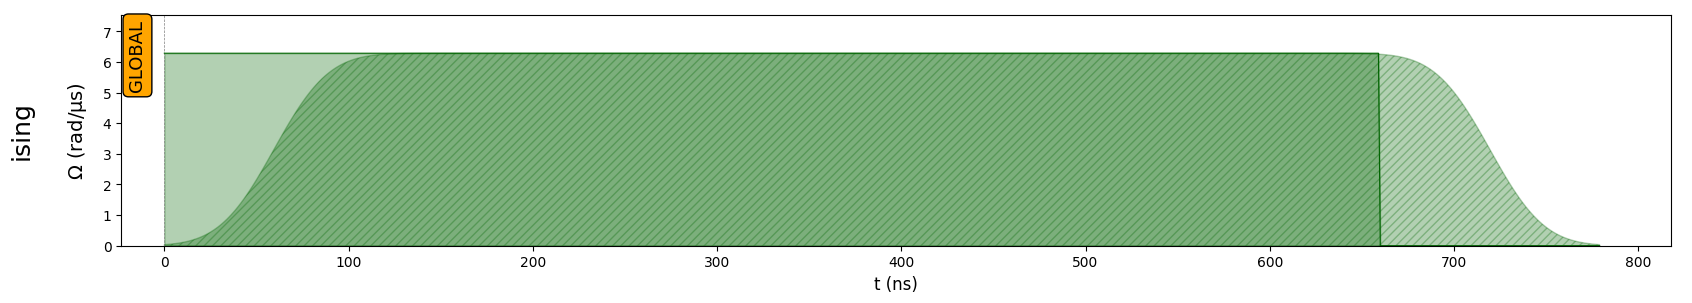

In [10]:
dataset_example = processed_dataset[64]
dataset_example.draw_sequence()

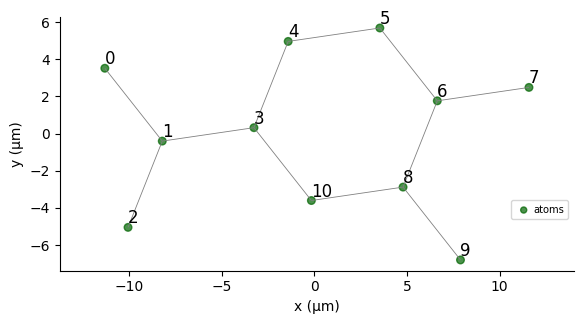

In [11]:
dataset_example.draw_register()

The results of executing the embedding on the Quantum Device are in field `state_dict`:

In [12]:
display(dataset_example.state_dict)
print(f"Total number of samples: {sum(dataset_example.state_dict.values())}")

{'00100000100': 15,
 '00100010010': 13,
 '10100100001': 7,
 '10000100000': 2,
 '10000000010': 29,
 '10000001010': 43,
 '01000000000': 20,
 '10000000000': 33,
 '10100001011': 3,
 '00001010001': 2,
 '01000001010': 9,
 '01000000100': 7,
 '00110000000': 6,
 '00100101010': 2,
 '10000000001': 13,
 '10010101100': 3,
 '01000010001': 8,
 '00000000000': 11,
 '00100000010': 21,
 '00100001100': 24,
 '01001010010': 2,
 '10000001001': 13,
 '00110001010': 15,
 '00101000010': 3,
 '00100010001': 4,
 '00110010010': 9,
 '10001001000': 4,
 '00100100010': 3,
 '00100000001': 6,
 '01000010010': 17,
 '10100001000': 8,
 '10110000100': 2,
 '10000010000': 11,
 '00010000000': 3,
 '00101001000': 2,
 '00100000000': 40,
 '00110000010': 11,
 '00100100011': 5,
 '10010000000': 17,
 '00100001010': 38,
 '10000001000': 16,
 '10001010011': 1,
 '10001010010': 5,
 '10000001100': 16,
 '10110000000': 7,
 '10010010010': 6,
 '00100001001': 19,
 '10010000010': 7,
 '00101001011': 3,
 '00101000100': 1,
 '10101001001': 5,
 '10100100

Total number of samples: 1000


This dictionary represents an approximation of the quantum state of the device for this graph after completion of the algorithm.

- each of the keys represents one possible state for the register (which represents the graph), with each qubit (which represents a single node) being in state `0` or `1`;
- the corresponding value is the number of samples observed with this specific state of the register.

In this example, for instance, we can see that the state observed most frequently is `10000001010`, with 43/1000 samples.

## Machine learning-features

From the state dictionary, we derive as machine-learning feature the _distribution of excitation_. We'll use this in a second to define our kernel.


ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (13,) and arg 1 with shape (12,).

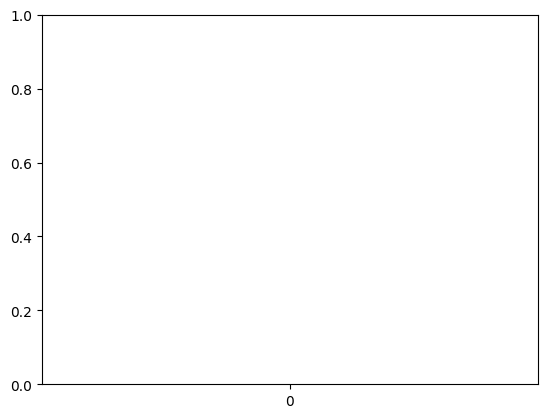

In [13]:
dataset_example.draw_excitation()


# Train your first quantum machine learning algorithm

The next step is to use the results of the Quantum Device execution on a classical device
(i.e. your computer) to create a Quantum Evolution Kernel. Since our algorithm combines steps that
are executed on a Quantum Device and steps that are executed on a classical device, we call this
a _hybrid algorithm_.


## Introducing the Quantum Evolution Kernel

For a graph $G$, let's call the excitation distribution $P_G$.

We may now construct the Quantum Evolution Kernel, or QEK. Mathematically, QEK defined as:
$$
K(G, G') = \exp \left( -\mu JS(P_G, P_{G'}) \right)
$$


where $\mu$ is an hyperparameter of our kernel and $JS$ is the Jensen-Shannon distance.

In [13]:
from qek.kernel import QuantumEvolutionKernel as QEK
kernel = QEK(mu=2.)

Parameter $\mu$ controls the rate of exponential decay. A large value of $\mu$ makes QEK very sensitive to small variations of the Jensen-Shanon distance. Conversely, when $\mu$ is small, the kernel is less affected by small variations in of $JS$.

QEK compares two processed graphs by their distribution of excitations. If `a` and `b` are two graphs, a value of `kernel(a, b)` close to 1 indicates a big similarity between graphs `a` and `b`, while a value close to 0 means a small graph similarity.

Let's try that:

In [ ]:
graph_1 = processed_dataset[2]
graph_1.draw_register()
graph_1.draw_excitation()
print(f"Comparing a graph with itself: {kernel(graph_1=graph_1, graph_2=graph_1)}")

NameError: name 'processed_dataset' is not defined

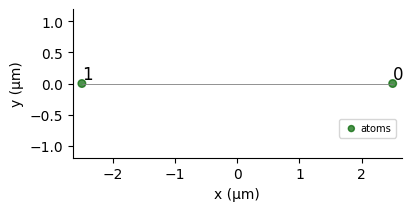

Comparing two non similar graphs: 0.3769509292862506


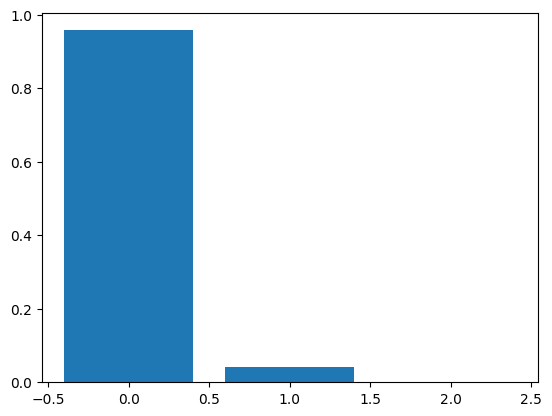

In [21]:
graph_2 = processed_dataset[0]
graph_2.draw_register()
graph_2.draw_excitation()
print(f"Comparing two non similar graphs: {kernel(graph_1=graph_1, graph_2=graph_2)}")

## Training and evaluation

In this part, we will calculate the kernel on the entire dataset of PTC-FM. We obtain an NxN matrix (where N is the number of graphs in the dataset). This matrix contains the similarities two by two of the graphs.

This precomputed kernel will allow us to evaluate the algorithm QEK. We will use an SVM (Support Vector Machine) to learn how to predict the toxicity of a molecule based on the precomputed kernel. This task is handled with the `train_and_evaluate_ml_model`.

In [16]:
train_kernel = kernel.fit_transform(processed_dataset)
y_tot = [data.target for data in processed_dataset]

In [17]:
import sklearn.svm as svm
from sklearn.metrics import balanced_accuracy_score, f1_score, make_scorer
from sklearn.model_selection import GridSearchCV, RepeatedStratifiedKFold


@dataclass
class MLResults:
    """
    Stores the results of a machine learning model evaluation.
    
    This class provides attributes to store the mean and standard deviation of F1 score 
    and balanced accuracy, which are common metrics used in classification problems.

    Attributes:
        f1_score (float): Mean F1 score of the model.
        std_f1_score (float): Standard deviation of F1 scores across different folds.
        balanced_acc (float): Mean balanced accuracy of the model.
        std_balanced_acc (float): Standard deviation of balanced accuracies across different folds.
    """
    f1_score: float
    std_f1_score: float
    balanced_acc: float
    std_balanced_acc: float


def train_and_evaluate_ml_model(K: np.ndarray, targets: list[int], seed1: int = None,
                                seed2: int = None):
    """
    Trains and evaluates a Support Vector Machine (SVM) model on the provided kernel.

    It employs a stratified k-fold cross-validation strategy with repeated splits
    to ensure robustness and reliability of the results.

    Parameters:
        K (np.ndarray): The precomputed kernel matrix.
        targets (list[int]): A list of target values for the training data.
        seed1 (int, optional): The random state used for stratified k-fold cross-validation.
            Defaults to None.
        seed2 (int, optional): The random state used for the SVM estimator. Defaults to None.

    Returns:
        MLResults: An instance containing the mean and standard deviation of F1 score and
            balanced accuracy.
    """
    C_list = np.linspace(0.001, 100, 100)
    param_grid = {"C": C_list}
    scoring = {"balanced_accuracy": make_scorer(balanced_accuracy_score),
                "f1_score": make_scorer(f1_score, average="weighted")
                }

    skf = RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=seed1)


    estimator = svm.SVC(kernel="precomputed", random_state=seed2)
    grid_search = GridSearchCV(estimator, param_grid, scoring=scoring,
                                    cv=skf, refit=False, n_jobs=8)
    

    result = grid_search.fit(K, targets).cv_results_
    max_f1_score = np.mean(result["mean_test_f1_score"]) 
    final_f1_std = np.mean(result["std_test_f1_score"])
    max_bal_acc = np.mean(result["mean_test_balanced_accuracy"]) 
    std_bal_acc = np.mean(result["std_test_balanced_accuracy"])
    final_score = MLResults(f1_score=max_f1_score, std_f1_score=final_f1_std,
                            balanced_acc=max_bal_acc, std_balanced_acc=std_bal_acc)
    return final_score

In [18]:
results = train_and_evaluate_ml_model(K=train_kernel, targets=y_tot, seed1=42, seed2=42)

### Results

We are using two metrics:
- The F1 score is a way to measure how well a model performs, especially when the data is uneven (e.g., more examples of one category than another). It combines two important aspects: how precise the model is (how many of the predicted positives are actually positive) and how well it captures all the actual positives (recall). It provides a single number that balances these two aspects, making it useful for evaluating performance in real-world scenarios where some categories are much more common than others.

- Balanced accuracy is a method to evaluate a model's performance fairly, even when the data is imbalanced (e.g., one category is much more frequent than others). Instead of just looking at overall accuracy, which can be misleading in such cases, balanced accuracy considers how well the model performs for each category separately and then averages these performances. This ensures that the evaluation is not skewed by the more common categories, giving a more honest picture of the model's effectiveness across all categories.


Inside the `train_and_evaluate_ml_model`function, we split our data multiple times to ensure each fold is representative of the overall class distribution, helping to mitigate bias. The mean value and standard deviation (std) of each metrics from this process provide an average performance measure and the variability of that performance across different data splits, giving you a robust understanding of your model's consistency and reliability.


In [19]:
print(f"Mean F1 score = {results.f1_score}")
print(f"Standard deviation of F1 score = {results.std_f1_score}")
print(f"Mean balanced accuracy {results.balanced_acc}")
print(f"Standard deviation of balanced accuracy {results.std_balanced_acc}")

Mean F1 score = 0.5657161375287069
Standard deviation of F1 score = 0.05822871989019115
Mean balanced accuracy 0.5539350131752306
Standard deviation of balanced accuracy 0.05879418899293764
